Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(51

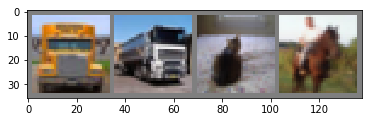

In [16]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

#define transform
#hint: Normalize(mean, var) to normalize RGB
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
#define trainloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
#define testloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)
#define class
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#define the network
cfg = {
    'VGG11':[64, 'M', 128, 'M', 256, 'M', 512, 'M', 512, 'M'],
    'VGG13':[64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16':[64, 64, 64, 'M', 128, 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
}
class Net(nn.Module):
    def __init__(self, vgg_name):
        super(Net, self).__init__()
        self.features = self._make_layer(cfg[vgg_name])
        self.classifer = nn.Linear(512, 10)
        
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out
    
    def _make_layer(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(x),
                    nn.ReLU(True)
                ]
                in_channels = x
        return nn.Sequential(*layers)

net = Net('VGG11')
if torch.cuda.is_available():
    net.cuda()
print(net)
#define loss
cost = nn.CrossEntropyLoss()
#define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start')
#iteration for training
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = cost(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print loss result
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d]  loss: %.3f'%(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.001
print('done')

#get random image and label
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('groundTruth: ', ''.join('%6s' %classes[labels[j]] for j in range(4)))

#get the predict result
outputs = net(Variable(images.cuda()))
_, pred = torch.max(outputs.data, 1)
print('prediction: ', ''.join('%6s' %classes[labels[j]] for j in range(4)))

#test the whole result
correct = 0.0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels.cuda()).sum()
print('average Accuracy: %d %%' %(100*correct / total))

#list each class prediction
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, pred = torch.max(outputs.data, 1)
    c = (pred == labels.cuda()).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += float(c[i])
        class_total[label] += 1
print('each class accuracy: \n')
for i in range(10):
    print('Accuracy: %6s %2d %%' %(classes[i], 100 * class_correct[i] / class_total[i]))
